# Preprocesamiento para Experimentos de altísima frecuencia y grandes conjuntos de datos
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos. En este cuaderno asumimos que ya se cortó o no fue necesario hacerlo. Para cortar revisar el programa CortarMatriz.jl en la carpeta Isabel.

In [4]:
push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../Isabel/")
using Z_auxiliaresBRW
using PreprocTools
using HDF5, PyPlot, Statistics
using ArraySetTools

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/Z_auxiliaresBRW.ji for Z_auxiliaresBRW [top-level]
└ @ Base loading.jl:1190


In [5]:
arxname="/home/karel/BRWFiles/Isabel2019/Cacho_04_control_02.brw" 

"/home/karel/BRWFiles/Isabel2019/Cacho_04_control_02.brw"

Vamos a hacer que pueda abrir tanto un brw original como un cacho arreglado o manipulado.
Tratemos de que funcione con los nuevos unicamente. Luego vemos si generalizamos.

In [11]:
if occursin("Cacho", arxname)
    arx=h5open(arxname)
    nota=read(arx["notacacho"])
    print(nota)
else
    arx=brw_things(arxname)
    print("Estas partiendo de un brw original")
end

freq=read(arx["SamplingRate"])/1000 # usamos kHz y milisegundos aqui porfa
dataraw=read(arx["dset"])
factor=read(arx["Factor"])
listchans=read(arx["Chs"])
evocado=false

Este es un intervalo de un dataset mas grande. 

                    Contiene los cuadros de 1205245 a 1606992.

false

In [19]:
tamanos=size(dataraw)
if length(tamanos)==2
    ncuadros=tamanos[2]
else
    tot=tamanos[1]
    ncuadros=Int(tamanos/4096)
end

401748

In [15]:
#Estas medidas estan en cuadros, no en ms.
if evocado
    retrazo=round(Int, ceil(5*freq))
    final=round(Int, ceil(60*freq))
    latencia=round(Int, ceil(1.5*freq))
else
    retrazo, final, latencia = 0, 0, 0
end

(0, 0, 0)

In [20]:
tiempototalms=round(ncuadros/freq; digits=1) 
println("Tienes ", ncuadros, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 401748 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  22500.0ms.


In [22]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(dataraw)[1] != 4096
reshape!(dataraw, (4096, Datos["numcuadros"]))
end;

In [14]:
size(DatosCrudosArreglados)

(4096, 2000)

In [24]:
lfp=FormaMatrizDatosCentrados(dataraw, factor);
# libera memoria
# dataraw=0

In [25]:
function checmal(dats::Array, umbr=1900)
   n=length(findall(x->x>umbr, dats))
    m=length(dats)
    u=n/m
    print(u, " ", n, " ", m, " ")
    return u
end

function bsst(datos::Array, 
                        desde=0.5, hasta=10,
                        freq=deffreq,
                         saturavalue=1900, tol=0.1)
    #busca saturados por promedio sobre umbral
    # cambios para guardar en HDF5 y mandar jld a freir esparragos.
    # no more Sets, only Arrays
    (alto,ancho,largo)=size(datos)
    cini=round(Int, ceil(desde*freq))
    cfin=round(Int, ceil(hasta*freq))
    #result=Set{Array{Int,1}}()
    result=Set(Array{Int8, 1}[])
    for j=1:ancho, k=1:alto
        sepasa=findall(x->x>saturavalue, datos[k,j,cini:cfin])
        enemalos=length(sepasa)
        enetotal=length(cini:cfin)
        fafa=enemalos/enetotal
        if fafa>tol
            print(" ", j," ", k, " => ", fafa, ". " )
            bla=[k, j]
            result=push!(result, bla)
        #    println(prom," ",[k,j]," ",saturavalue," ", desde, " ",hasta)
        end
    end
    #result=permutedims(hcat(result[2:end,:]...), [2,1])
    return result
end


bsst (generic function with 6 methods)

In [28]:
nr=(52, 54, 57, 46)
nc=(28, 28, 33, 44)
for (ren, col) in zip(nr, nc)
    lfpejemplo=vec(lfp[ren,col,:])
    print(ren," ", col, " ", "\n")
    checmal(lfpejemplo, 3000)
end

52 28 
0.0 0 401748 54 28 
0.0 0 401748 57 33 
0.0 0 401748 46 44 
0.0 0 401748 

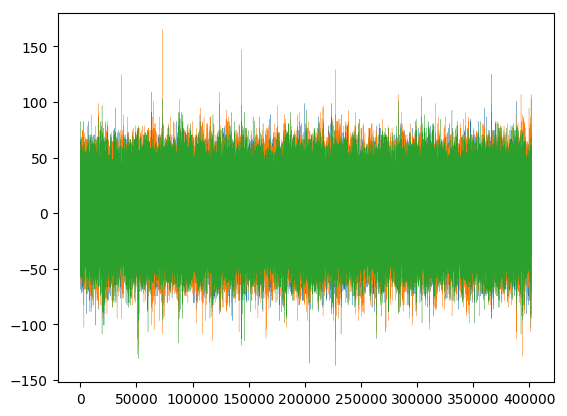

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8bebdbc588>

In [30]:
plot(vec(lfp[52,28,:]), lw=0.2)
plot(vec(lfp[53,28,:]), lw=0.2)
plot(vec(lfp[54,28,:]), lw=0.2)

In [31]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=buscaCanalPicos(lfp, 1, 200, freq,-110,-900)
# y luego los saturados
iniciobusqueda=1
finbusqueda=282
#satu=bsst(DatosCentrados,iniciobusqueda,finbusqueda,freq,1000, 0.04)

satu=BuscaSaturados(lfp,iniciobusqueda,finbusqueda,freq,1000, 0.04)

numerosaturados=length(satu)
println("Encontramos ", numerosaturados, " canales probablemente saturados.")
println("Encontramos ", length(PruebaRespuesta), " canales probablemente con actividad.")


Estoy buscando del cuadro 18 al , 3572
Encontramos 18 canales probablemente saturados.
Encontramos 33 canales probablemente con actividad.


In [32]:
quietos=BuscaSaturadosStd(lfp, iniciobusqueda,finbusqueda, freq, 15,10000)
intensos=BuscaSaturadosStd(lfp, iniciobusqueda, finbusqueda, freq, 0, 30)
numerosaturados=length(quietos)
println("Encontramos ", numerosaturados, " canales muy quietos")
numerosaturados=length(intensos)
println("Encontramos ", numerosaturados, " canales muy intensos")



Encontramos 16 canales muy quietos
Encontramos 41 canales muy intensos


In [34]:
ruidosos=BuscaRuidosos(lfp, iniciobusqueda, finbusqueda, freq,200,15)
numerosaturados=length(ruidosos)
println("Encontramos ", numerosaturados, " canales con ruido alto")

Encontramos 25 canales con ruido alto


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [36]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(lfp[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end

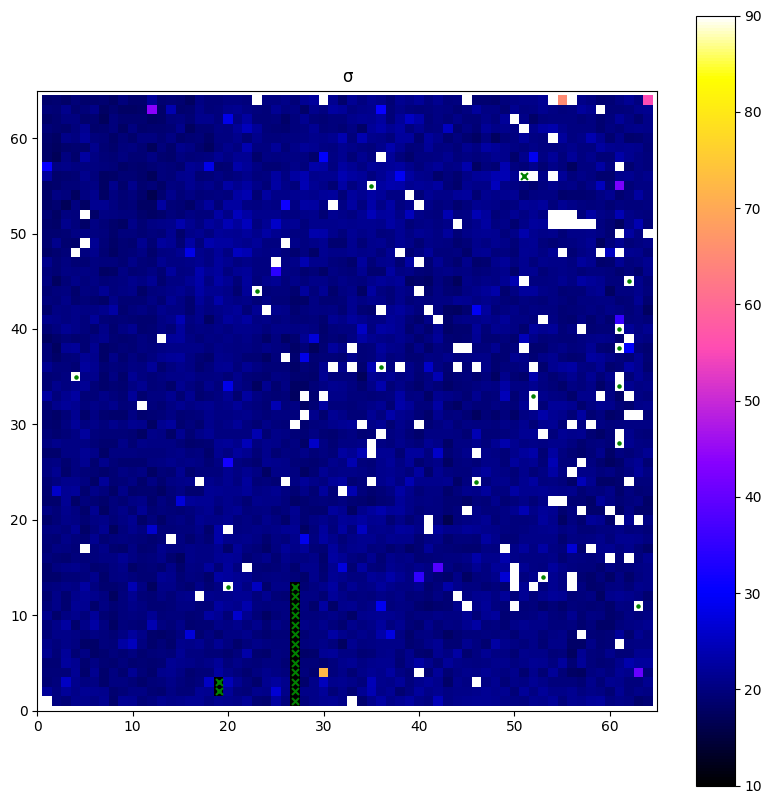

PyObject <matplotlib.collections.PathCollection object at 0x7f8bebc89c50>

In [38]:
figure(figsize=(10,10))
xlim(0,65)
ylim(0,65)
title("σ")
limites=90
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="gnuplot2", 
                      vmin=10,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar()

x=[]
y=[]
for j in PruebaRespuesta
  append!(x,j[2])
   append!(y,j[1])
end


x2=[]
y2=[]
for j in satu
  append!(x2,j[2])
   append!(y2,j[1])
end


x3=[]
y3=[]
for j in quietos
  append!(x3,j[2])
   append!(y3,j[1])
end


x4=[]
y4=[]
for j in intensos
  append!(x4,j[2])
   append!(y4,j[1])
end


x5=[]
y5=[]
for j in ruidosos
  append!(x5,j[2])
   append!(y5,j[1])
end





#scatter(x,y, marker="o",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)
scatter(x3,y3, marker="x",c="green", s=25)
#scatter(x4,y4, marker="+",c="lightblue", s=25)
#scatter(x5,y5, marker="v",c="green", s=25)



"ruidosos" parece ser totalmente redundante. No aporta nada que no sea JUSTO lo que no nos interesa: la union de lo peor y lo mejor.
Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [40]:
egtrazo=lfp[23,4,:];

In [41]:
using Statistics

In [42]:
mean(egtrazo)

1.0228425f0

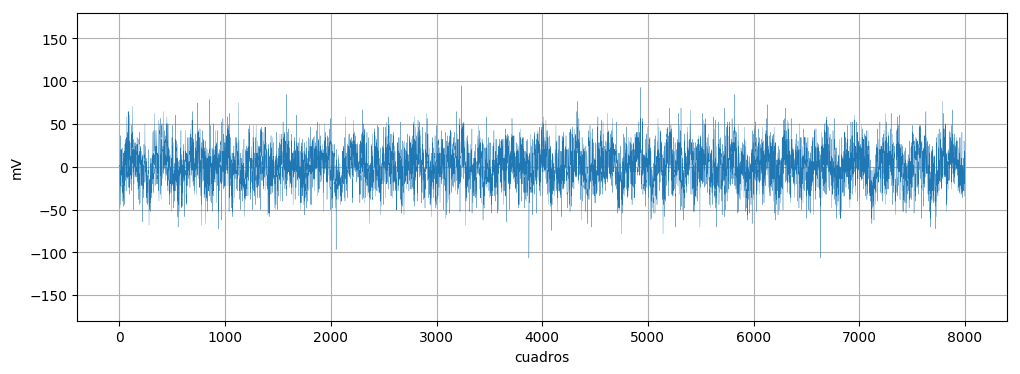

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8beba1a240>

In [46]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-180,180)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=1
hasta=8000
#intervalo=1:cacho
intervalo=desde:hasta
grid()
plot(intervalo,egtrazo[intervalo], lw=0.22)

In [47]:
mal=union(quietos, satu)
buenos=union(intensos, PruebaRespuesta)
setdiff!(buenos, mal)

Set(Array{Int8,1}[[60, 58], [26, 20], [51, 63], [48, 16], [52, 61], [6, 3], [54, 30], [1, 1], [38, 62], [57, 33]  …  [55, 8], [56, 28], [20, 58], [52, 54], [52, 58], [57, 18], [32, 30], [56, 38], [52, 55], [51, 54], [56, 32]])

In [48]:
malforsave=elemtorow(mal)
buenforsave=elemtorow(buenos);

In [50]:
size(lfp)

(64, 64, 401748)

8000

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [52]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, "_preproc.h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "CanalesBuenos" => buenforsave,
     "CanalesMalos" => malforsave)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

UndefVarError: UndefVarError: stringgeneral not defined

In [38]:
typeof(listaaguardar)

Dict{String,Any}

In [35]:
freq

7.022058198545425